# Loss Distribution Builder

We build a credit default loss distribution first for a homogeneous portfolio and then for a inhomogeneous portfolio. I compare the result with my fast adjusted binomial approximation.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from financepy.models.gauss_copula_onefactor import *

## The Homogeneous Credit Portfolio

We set the portfolio size 

In [2]:
num_credits = 500

We set the market factor weight and homogeneous default probability

In [3]:
beta = 0.50
defaultProb = 0.30

We set the credit quality and factor correlation for each credit, here all assumed to be the same

In [4]:
default_probs = np.ones(num_credits) * defaultProb
beta_vector = np.ones(num_credits) * beta

We also define the vector of loss units that defines the number of units of loss for each credit. Here we assume that the default of each credit results in the same loss of one.

In [5]:
lossUnits = np.ones(num_credits)

There is an internal integration over the Gaussian market factor

In [6]:
num_steps = 100

Now we determine the full loss distribution

In [7]:
%%time
dbn1 = loss_dbn_recursion_gcd(num_credits, default_probs, lossUnits, beta_vector, num_steps)

Wall time: 34.9 ms


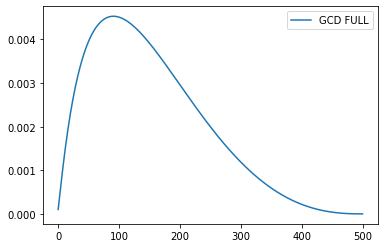

In [10]:
x = np.linspace(0, num_credits, num_credits + 1)
plt.figure()
plt.plot(x, dbn1, label='GCD FULL')
plt.legend()
plt.show()

## Using Fast Approximate Scheme

The call is identical.

In [11]:
%%time 
dbn2 = loss_dbn_hetero_adj_binomial(num_credits, default_probs, lossUnits, beta_vector, num_steps)

Wall time: 969 µs


We can plot them both

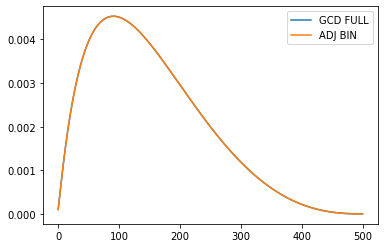

In [12]:
x = np.linspace(0, num_credits, num_credits + 1)
plt.figure()
plt.plot(x, dbn1, label='GCD FULL')
plt.plot(x, dbn2, label='ADJ BIN')
plt.legend()
plt.show()

The difference is computed simply as follows

In [13]:
diff = dbn2 - dbn1

We can also set the put schedule - the price and date on which the owner can put back the bond to the issuer. This is given with reference to a price of 100. Making the put price very low means it will never be put.

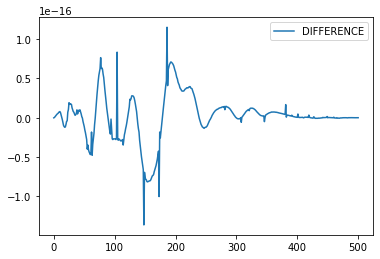

In [14]:
x = np.linspace(0, num_credits, num_credits + 1)
plt.figure()
plt.plot(x, diff, label='DIFFERENCE')
plt.legend()
plt.show()

This is negligible. The approximate method is 10-20 times faster than the exact method for effectively the same result. This is good. But we need to see how it does on an inhomogeneous credit portfolio.

## Inhomogeneous Credit Portfolio

In [15]:
num_credits = 200
beta = 0.50
defaultProb = 0.10
num_steps = 500

Note that these all have to be vectors of floats which is why I divide them by a float

In [16]:
default_probs = np.random.randint(1,3, size=(num_credits)) / 10.0
beta_vector = np.random.randint(2,10, size=(num_credits)) / 10.0
lossUnits = np.random.randint(1,10, size=(num_credits)) / 1.0

In [17]:
%%time
dbn1 = loss_dbn_recursion_gcd(num_credits, default_probs, lossUnits, beta_vector, num_steps)

Wall time: 141 ms


In [18]:
numLossUnits = int(lossUnits.sum())
x1 = np.linspace(0, numLossUnits, numLossUnits + 1)

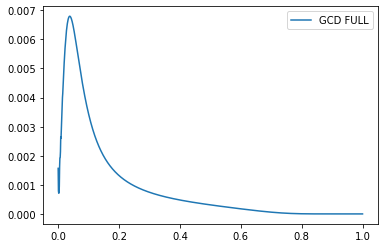

In [19]:
plt.figure()
plt.plot(x1/numLossUnits, dbn1, label='GCD FULL')
plt.legend()
plt.show()

In [20]:
averageLoss = lossUnits.sum() / num_credits
loss_ratio = lossUnits / averageLoss

In [21]:
%%time 
dbn2 = loss_dbn_hetero_adj_binomial(num_credits, default_probs, loss_ratio, beta_vector, num_steps)

Wall time: 2.99 ms


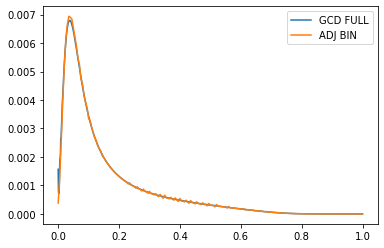

In [22]:
x2 = np.linspace(0, num_credits, num_credits + 1) * averageLoss
plt.plot(x1/numLossUnits, dbn1, label='GCD FULL')
plt.plot(x2/numLossUnits, dbn2 / averageLoss, label='ADJ BIN')
plt.legend()
plt.show()

The agreement is very good but we cannot subtract the two distributions as they have different supports